In [60]:
import json
import os
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

from ipwhois.asn import IPASN
from ipwhois.net import Net
import numpy as np

In [61]:
ROUTE_DIR = "outputquic100/"
URL_FILE = "../../cf-clusters-datasets/quic-100p-150.txt"

In [62]:
def print_overall(ROUTE_DIR, URL_FILE):
    
    with open(URL_FILE) as f:
        urls = f.readlines()
        urls = [x.strip() for x in urls]
    print("Dataset:", ROUTE_DIR)
    print('Total number of pages in dataset', len(urls))
    dirnames = os.listdir(ROUTE_DIR)
    dirnames = [x for x in dirnames if x in urls]
    print("Total number of successful page traceroutes:", len(dirnames))
    
    return dirnames, len(dirnames)

In [63]:
def get_as_info(filename, dirname, output_dir):

    full_name = os.path.join(output_dir, dirname, filename)
    with open(full_name) as f:
        data = json.loads(f.read())

    #print(data[0]['result'][0].keys())
    asn_list = []
    result = data[0]['result']
    ip_list = []

    for item in result:
        hop_result = item['result'][0]
        asn = hop_result['asn']
        ip = hop_result['from']
        asn_list.append(asn)
        ip_list.append(ip)

    return asn_list, ip_list

In [64]:
def plot_distribution(data, bins=0, title="", xlabel="", ylabel=""):
    
    
    #plt.title(title)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(12,6))
    plt.tick_params(labelsize=22)
    plt.xlabel(xlabel, fontsize=26)
    plt.ylabel(ylabel, fontsize=26)
    if bins > 0:
        plt.hist(data, bins=bins)
    else:
        plt.hist(data)
    plt.grid()
    plt.show()

In [83]:
def process_traceroute_info(route_dir, dirnames):

    resources_per_site = []
    asns_per_route = []
    total_routes = 0
    perc_asterisks = []
    hops_per_route = []
    num_ip_no_as = 0
    num_no_ip_no_as = 0
    num_hops = 0
    ips_to_lookup = []
    seen_dict = {}
    asn_dict = {}

    for dirname in dirnames:
        seen_persite_dict = {}
        seen_dict[dirname] = {}
        persite_routes = 0
        filenames = os.listdir(os.path.join(route_dir, dirname))
        total_routes += len(filenames)
        resources_per_site.append(len(filenames))
        persite_routes += len(filenames)

        for filename in filenames:
            if 'firefox' in filename:
                continue
            asn_list, ip_list = get_as_info(filename, dirname, route_dir)
            asterisk_list = [x for x in asn_list if x == '*']
            good_asn_list = [x for x in asn_list if x != '*']
            asn_list_noends = asn_list[1:-1]
            good_asn_list_noends = [x for x in asn_list_noends if x != '*']
            perc_asterisk = float(len(asterisk_list))/len(asn_list) * 100
            perc_asterisks.append(perc_asterisk)
            hops_per_route.append(len(asn_list))
            asns_per_route.append(len(set(good_asn_list)))

            for item in set(good_asn_list):
                if item not in seen_persite_dict:
                    seen_persite_dict[item] = 0
                seen_persite_dict[item] += 1

            for item in set(good_asn_list):
                if item not in asn_dict:
                    asn_dict[item] = 0
                asn_dict[item] += 1

        for k, v in seen_persite_dict.items():
            perc_seen = v/persite_routes * 100
            seen_dict[dirname][k] = perc_seen

    print("Total number of routes:", total_routes)
    
    return perc_asterisks, seen_dict

In [67]:
def calculate_asn_stats(seen_dict):

    all_means = []
    all_max = []
    minval = 30
    minsite = ""
    asn_seen_per_site = {}
    asn_seen_numsite = {}

    for k, v in seen_dict.items():
        perc_seen = []
        for k1, v1 in v.items():
            perc_seen.append(v1)
        # plt.hist(perc_seen)
        # plt.ylabel("Number of ASNs")
        # plt.xlabel("% of routes seen")
        # plt.savefig("../figs/routes_per_asn/" + k + ".png")
        # plt.clf()
        #print(k, np.mean(perc_seen), np.std(perc_seen))
        #print(k, v)
        all_means.append(np.mean(perc_seen))
        all_max.append(max(perc_seen))
        for k1, v1 in v.items():
            if k1 not in asn_seen_per_site:
                asn_seen_per_site[k1] = []
            if k1 not in asn_seen_numsite:
                asn_seen_numsite[k1] = 0
            asn_seen_numsite[k1] += 1
            asn_seen_per_site[k1].append(v1)
            
    return asn_seen_per_site, asn_seen_numsite

def process_asn_stats(asn_seen_per_site, asn_seen_numsite, total_sites):
    
    asn_seen_per_site_processed = {}
    for k, v in asn_seen_per_site.items():
        asn_seen_per_site_processed[k] = {'mean' : np.mean(v), 'std' : np.std(v)}
        #print(k, np.mean(v), np.std(v))   

    asn_seen_per_site_processed = {k: v for k, v in sorted(asn_seen_per_site_processed.items(), key=lambda item: item[1]['mean'], reverse=True)}
    
    asn_seen_numsite_processed = {}
    for k, v in asn_seen_numsite.items():
        asn_seen_numsite_processed[k] = v/total_sites * 100

    asn_seen_numsite_processed = {k: v for k, v in sorted(asn_seen_numsite_processed.items(), key=lambda item: item[1], reverse=True)}  
    
    return asn_seen_per_site_processed, asn_seen_numsite_processed

In [68]:
def plot_numsite_seen(data):

    labels = data.keys()
    new_labels = []
    for item in labels:
        if "_" in item:
            new_label = item.split("_")[0] + "\\_" + item.split("_")[1]
            new_labels.append(new_label)
        else:
            new_labels.append(item)
    values = data.values()
    x = range(1, len(labels) + 1)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(12,6))
    plt.tick_params(labelsize=22)
    plt.bar(x, values)
    plt.xticks(x, new_labels, rotation=90)
    plt.ylabel("Pages seen (\%)", fontsize=26)
    plt.xlabel("AS Number", fontsize=26)
    plt.grid()
    plt.show()

def plot_persite_seen(data):

    labels = data.keys()
    new_labels = []
    for item in labels:
        if "_" in item:
            new_label = item.split("_")[0] + "\\_" + item.split("_")[1]
            new_labels.append(new_label)
        else:
            new_labels.append(item)
    means = []
    stds = []

    for k, v in data.items():
        means.append(v['mean'])
        stds.append(v['std'])

    x = range(1, len(labels) + 1)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(12,6))
    plt.tick_params(labelsize=22)
    plt.bar(x, means, yerr=stds)
    plt.xticks(x, new_labels, rotation=90)
    plt.ylabel("Mean routes seen per page (\%)", fontsize=26)
    plt.xlabel("AS Number", fontsize=26)
    plt.grid()
    plt.show()


In [85]:
def pipeline(route_dir, url_file):
    
    dirnames, total_sites = print_overall(route_dir, url_file)
    perc_asterisks, seen_dict = process_traceroute_info(route_dir, dirnames)
    asn_seen_per_site, asn_seen_numsite = calculate_asn_stats(seen_dict)
    asn_seen_per_site_processed, asn_seen_numsite_processed = \
        process_asn_stats(asn_seen_per_site, asn_seen_numsite, total_sites)
    plot_numsite_seen(asn_seen_numsite_processed)
    plot_persite_seen(asn_seen_per_site_processed)
#     plot_distribution(perc_asterisks, bins=20, title="\% Asterisks on route", \
#            xlabel="Asterisks on route (\%)",
#            ylabel="Number of routes")

Dataset: outputquic100/
Total number of pages in dataset 150
Total number of successful page traceroutes: 145
Total number of routes: 974


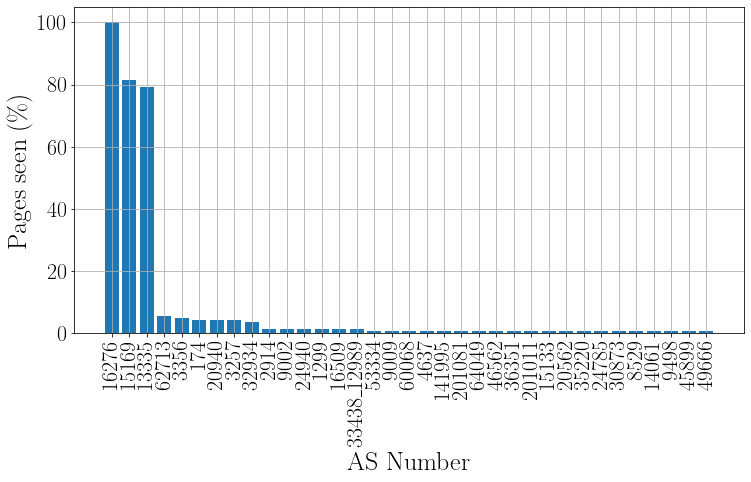

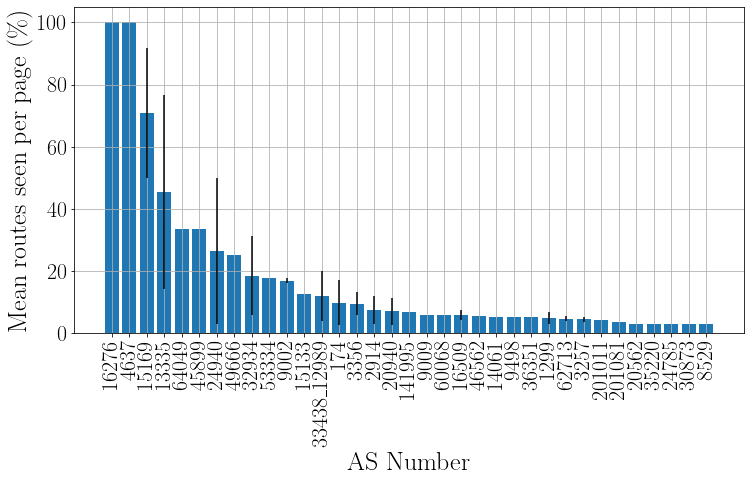

In [86]:
#quic100 experiment
pipeline(ROUTE_DIR, URL_FILE)

In [87]:
# Vantage point experiment
quic2 = "vantage/vp2"
quic3 = "vantage/vp3"
quic4 = "vantage/vp4"

QUIC2
Dataset: vantage/vp2
Total number of pages in dataset 150
Total number of successful page traceroutes: 140
Total number of routes: 1160


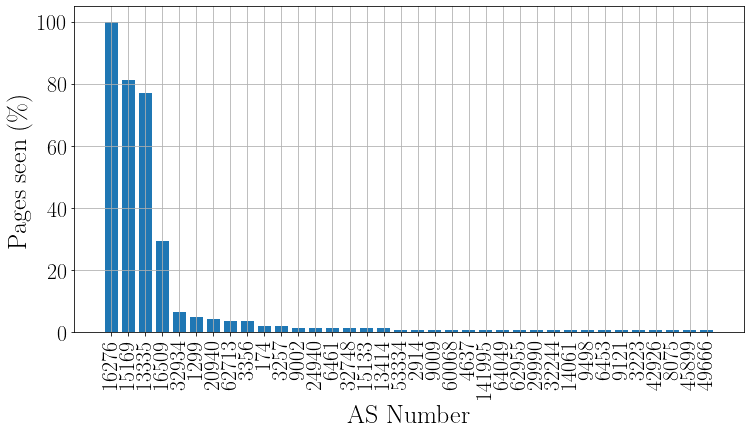

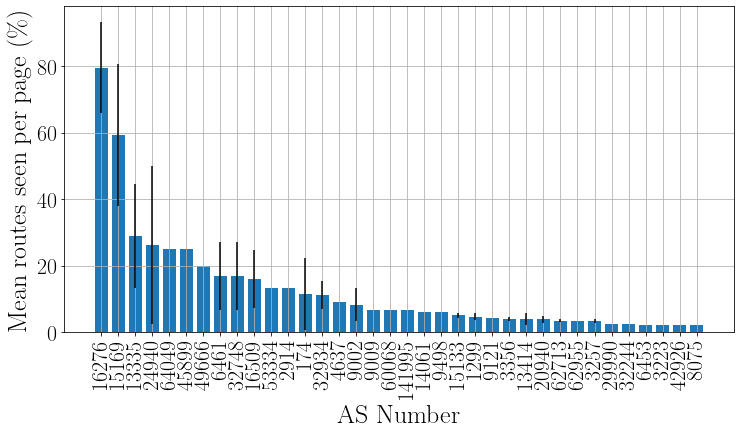

In [88]:
print("QUIC2")
pipeline(quic2, URL_FILE)

QUIC3
Dataset: vantage/vp3
Total number of pages in dataset 150
Total number of successful page traceroutes: 138
Total number of routes: 1108


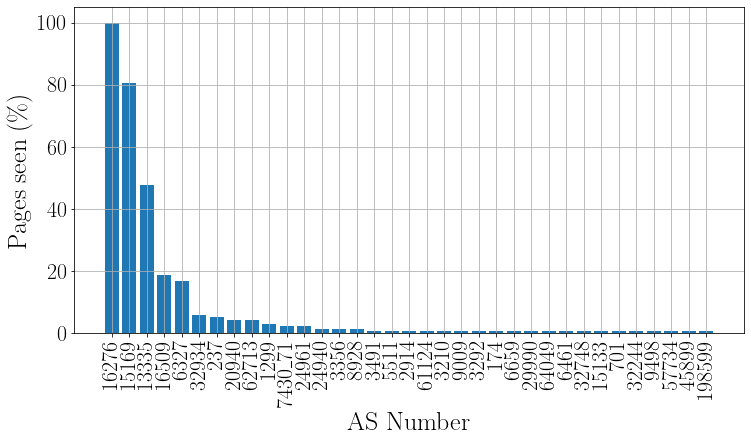

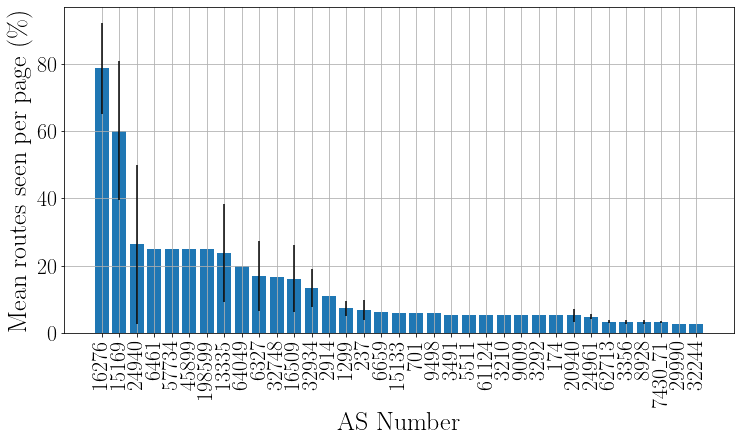

In [89]:
print("QUIC3")
pipeline(quic3, URL_FILE)

QUIC4
Dataset: vantage/vp4
Total number of pages in dataset 150
Total number of successful page traceroutes: 117
Total number of routes: 738


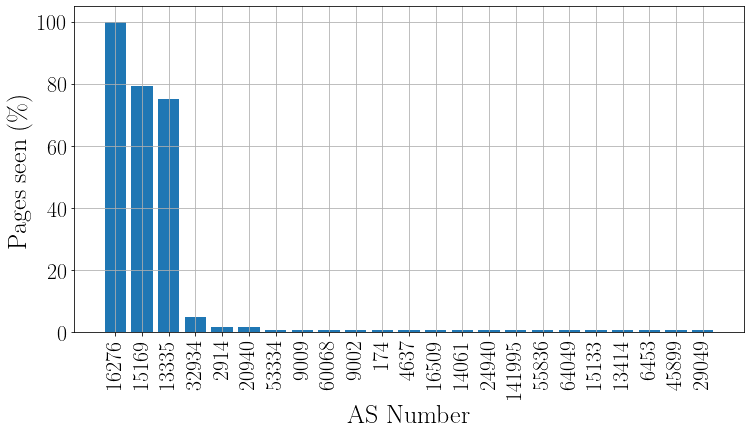

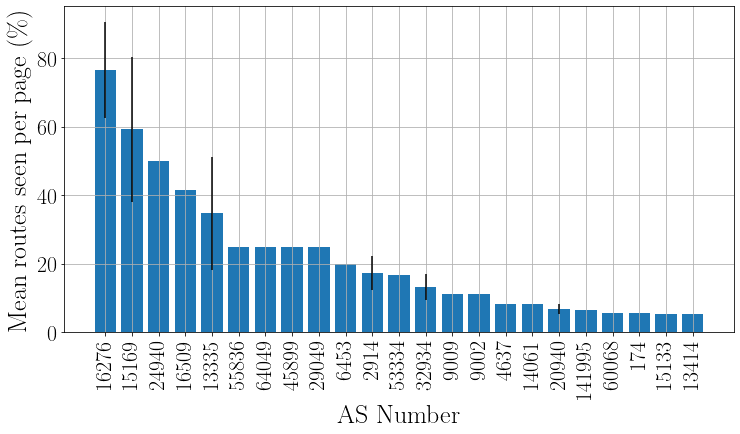

In [90]:
print("QUIC4")
pipeline(quic4, URL_FILE)